# <span style="color:lightblue"><center><b>CLASSIFICAÇÃO DOS ESTÁGIOS DA CIRROSE</b></center></span>

Neste notebook vamos realizar  um processo de classificação de Estágio da cirrose utilizando o dataset que fizemos na análise exploratória posterior, com a intenção de explorar e classificar a coluna "Estágio", que indica qual o estágio atual da cirrose do paciente. Com isso, faremos a criação de modelos de Regressão Linear, Árvore de Decisão e Redes Neurais para identificar o estágio atual da cirrose de um determinado paciente, com base nos dados de input, visando a melhor acurácia possível nos modelos.

---
### **Importando as Bibliotecas e Definindo Funções**
---


In [1]:
import pandas as pd # Manipulação de Tabelas
import matplotlib.pyplot as plt # Visualização de Dados
import numpy as np # Operações matemáticas
from matplotlib.colors import LinearSegmentedColormap # Manipulação de paletas de cores
from seaborn import heatmap # Mapa de Calor

---
### **Importação dos Dados**
---

* Para treinar os modelos, usaremos o arquivo csv "liver_cirrhosis_v2", que foi o arquivo previamente separado na etapa de limpeza de dados, removendo boa parte das variáveis do Dataframe e deixando apenas as mais importantes para a classificação dos estágios da cirrose.


In [2]:
df = pd.read_csv('../data/dados_processados/liver_cirrhosis_v2.csv')
df['Estágio'] = pd.factorize(df['Estágio'])[0]
df.head()

,Idade,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
0,18499,F,N,S,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,0
1,19724,M,S,N,S,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,1
2,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,1
3,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,1
4,21699,F,N,S,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,0


* Porém, como alguns dados categóricos se encontram em formato de texto, iremos fazer o tratamento desses dados.

In [3]:
categoric_columns = list(df.select_dtypes(include=['object']).columns)

df[categoric_columns].head()

,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema
0,F,N,S,N,N
1,M,S,N,S,N
2,F,N,N,N,N
3,F,N,N,N,N
4,F,N,S,N,N


---
### **Transformando os Dados de Categóricos para Numéricos**
---
* Sabemos que modelos de machine learning não se dão bem com dados categóricos em formato de string, que é o caso, e por isso vamos usar o método "pd.factorize( )" do pandas, que é usado para codificar valores de uma série ou coluna em números inteiros, transformando as classes de strings para int. Isso permitirá usarmos os dados no modelos de regressão logística;
* Após essa transformação, iremos substituir esses valores no dataframe.

In [4]:
colunas_binarias = {column:pd.factorize(df[column])[0] for column in df[categoric_columns].columns}
df[categoric_columns] = pd.DataFrame(colunas_binarias)
df[categoric_columns].head()

,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema
0,0,0,0,0,0
1,1,1,1,1,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,0


Como na coluna 'Sexo' o valor M (Masculino) tornou-se 1, iremos mudar o nome da coluna 'Sexo' para 'Sexo Masculino', onde 1 indicará o Sexo Masculino, e 0 indicará o Sexo Feminino. 

In [5]:
df.rename(
    columns={'Sexo':'Sexo Masculino'}, # Mudando 'Sexo' para 'Sexo Masculino', 
    inplace=True # Realiza a mudança no prórprio df
)

# Atualizando a lista de colunas categóricas
categoric_columns.remove('Sexo')
categoric_columns.insert(0,'Sexo Masculino')

df[categoric_columns].head()

,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema
0,0,0,0,0,0
1,1,1,1,1,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,0


#### **Transformando a Idade de Dias para Anos**
* Isso é pra uma questão mais prática, além de percebermos uma certa clareza no heatmap quando estávamos comparando com a idade em dias

In [6]:
df['Idade'] = (df['Idade']/365).astype(int)
df.head()

,Idade,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
0,50,0,0,0,0,0,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,0
1,54,1,1,1,1,0,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,1
2,32,0,0,1,0,0,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,1
3,45,0,0,1,0,0,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,1
4,59,0,0,0,0,0,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,0


---
### **Plotando o Mapa de Calor para Analisarmos as Correlações**
---
* Iremos analisar as correlações das variáveis numéricas com os dados previamente separados

In [7]:
# Gerar uma máscara para a metade superior e criar um mapa triangular
half_mask = np.triu(np.ones_like(df.corr(), dtype=bool))

<Axes: >

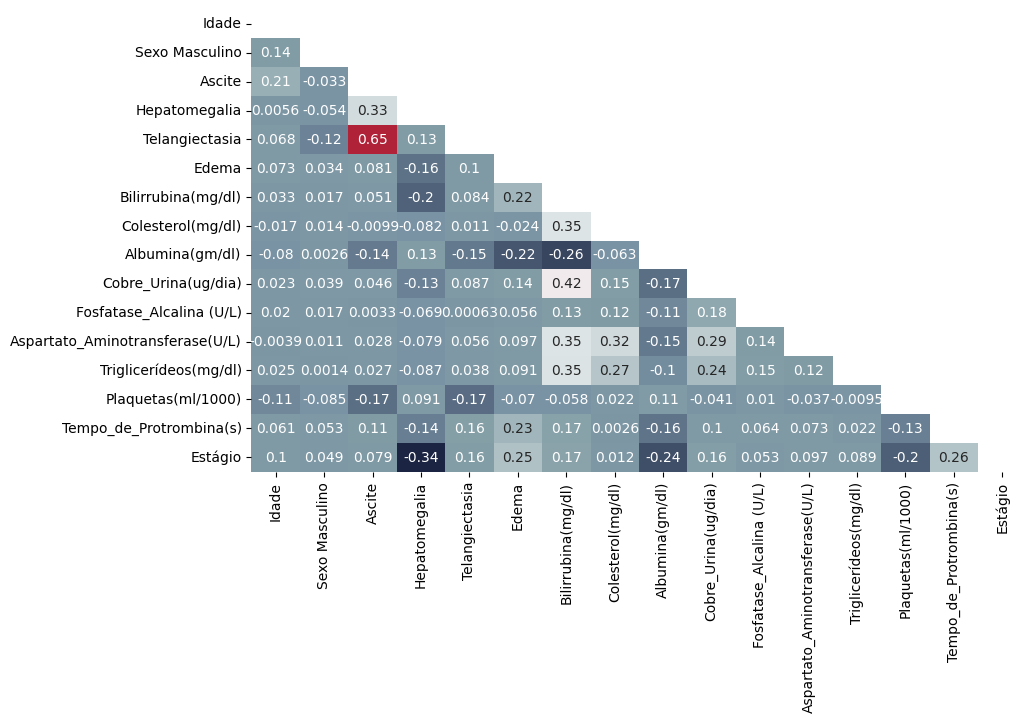

In [8]:
# Mapa de calor com as correlações
colors = ["#1b2442","#7992a4","#829da5","#f4f7f7","#b02238"]
cmap = LinearSegmentedColormap.from_list("custom_palette", colors, N=256)
plt.figure(figsize=[10,6])
heatmap(df.corr(),
        mask=half_mask, 
        annot=True, # Escreve os valores dos coeficientes
        cmap=cmap, # Paleta de cores
        cbar=False,
)

#### **Filtando os índices de correlação que possui módulo > 0.10**


In [9]:
mask = df.corr().abs() >+ 0.1
filtered = df.corr().where(mask)
filtered

,Idade,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
Idade,1.000000,0.138954,0.205923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.112695,NaN,NaN
Sexo Masculino,0.138954,1.000000,NaN,NaN,-0.124024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ascite,0.205923,NaN,1.000000,0.329621,0.649646,NaN,NaN,NaN,-0.143593,NaN,NaN,NaN,NaN,-0.169384,0.114120,NaN
Hepatomegalia,NaN,NaN,0.329621,1.000000,0.132154,-0.161125,-0.196951,NaN,0.134408,-0.125755,NaN,NaN,NaN,NaN,-0.135294,-0.336901
Telangiectasia,NaN,-0.124024,0.649646,0.132154,1.000000,0.100366,NaN,NaN,-0.146398,NaN,NaN,NaN,NaN,-0.171288,0.163029,0.155757
Edema,NaN,NaN,NaN,-0.161125,0.100366,1.000000,0.224647,NaN,-0.224724,0.139269,NaN,NaN,NaN,NaN,0.225660,0.254994
Bilirrubina(mg/dl),NaN,NaN,NaN,-0.196951,NaN,0.224647,1.000000,0.352127,-0.261299,0.415027,0.132425,0.352460,0.348504,NaN,0.170697,0.172219
Colesterol(mg/dl),NaN,NaN,NaN,NaN,NaN,NaN,0.352127,1.000000,NaN,0.145983,0.117626,0.322665,0.267340,NaN,NaN,NaN
Albumina(gm/dl),NaN,NaN,-0.143593,0.134408,-0.146398,-0.224724,-0.261299,NaN,1.000000,-0.168683,-0.112587,-0.147348,-0.103031,0.107514,-0.156307,-0.237199
Cobre_Urina(ug/dia),NaN,NaN,NaN,-0.125755,NaN,0.139269,0.415027,0.145983,-0.168683,1.000000,0.184010,0.285076,0.239766,NaN,0.101950,0.160070


<Axes: >

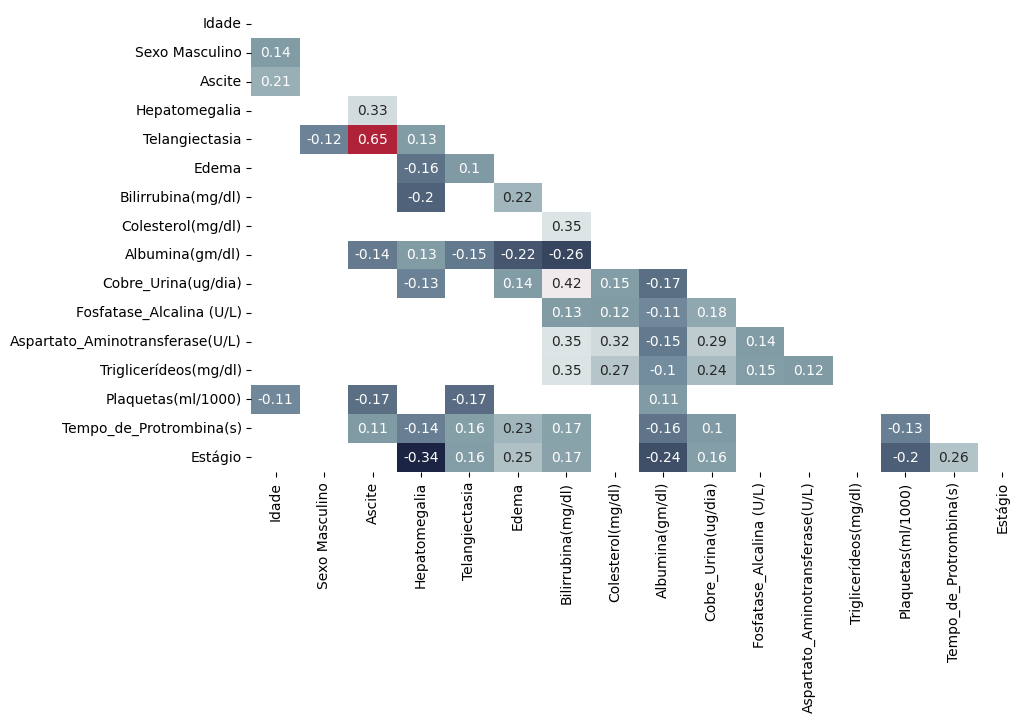

In [10]:
# Mapa de calor com as correlações cujo módulo >= 10
plt.figure(figsize=[10,6])
heatmap(
    filtered,
    mask=half_mask, 
    annot=True, # Escreve os valores dos coeficientes
    cmap=cmap, # Paleta de cores
    cbar=False
)


Perceba que Telangiectasia apresentou uma correlação positiva moderada quase forte com Ascite. Isso pode ser explicado pois: 

'Em geral, pacientes com hepatopatia e ascite apresentam outros estigmas de doença hepática, como presença de telangiectasias[...]'

> Disponível em: [Ascite no paciente cirrótico](https://www.medicinanet.com.br/conteudos/revisoes/5464/ascite_no_paciente_cirrotico.htm)

---
## **Desenvolvendo o Modelo**
---

#### **Importando Bibliotecas para Fazer o Modelo**

In [11]:
from sklearn.model_selection import train_test_split # Separação de dados de treino e teste
from sklearn.linear_model import LogisticRegression # Modelo de Regressão Logística
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # Feedback do modelo, matriz de confusão
from sklearn.preprocessing import StandardScaler # Padronizador de Dados
from joblib import dump # Salvar modelos

#### **Separação de Dados de Treino e Teste**

* Agora que os dados foram devidamente transformados, vamos separar nossa base de dados em conjuntos de treino e teste. Para isso, utilizamos o método `train_test_split` do scikit-learn:

* A princípio, iremos separar os dados entre as variáveis **preditoras** _(variáveis utilizadas para prever algo: X)_, e a variável **alvo** _(variável a ser prevista: Y)_. Nesse caso, vamos dividir 80% dos dados para treino e 20% para teste.


In [12]:
# Obtendo as variáveis x e y para treinar o modelo 
X = df.drop(columns=['Estágio']).values
Y = df['Estágio'].values 

# Dividindo 80% dos dados para treinar o modelo e 20% para os testes
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print("Tamanho separado para treinos: " + str(len(X_train)))
print("Tamanho separado para testes: " + str(len(X_test)) + "\n")

print(X)
print(Y)

Tamanho separado para treinos: 7709
Tamanho separado para testes: 1928

[[ 50.    0.    0.  ...  57.  256.    9.9]
 [ 54.    1.    1.  ...  75.  220.   10.8]
 [ 32.    0.    0.  ...  80.  225.   10. ]
 ...
 [ 67.    0.    0.  ...  84.  412.   11.8]
 [ 58.    0.    0.  ...  90.  228.   10.3]
 [ 78.    1.    1.  ...  99.   97.   11.2]]
[0 1 1 ... 2 1 2]


#### **Normalizando os Dados**
* Nessa etapa, iremos realizar a padronização dos dados. A padronização dos dados é um passo importante no pré-processamento para muitos algoritmos de machine learning. O objetivo da padronização é transformar os dados para que tenham uma média zero e um desvio padrão de um. 

* No código abaixo, utilizamos `StandardScaler` do scikit-learn para padronizar nossos dados de treino e teste:

In [13]:
# Normalizando as variáveis preditoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

# Salvando o scaler para uso futuro
print("O normalizador 'scaler' foi salvo em:")
dump(scaler, 'scalers/stage_scaler.joblib')

O normalizador 'scaler' foi salvo em:


['scalers/stage_scaler.joblib']

---
## **Regressão Logística**
---

* Nosso primeiro modelo de classificação será feito utilizando Regressão Logística. Vamos utilizar o objeto **Logistic Regression** e dar um *fit()* para poder treinar nosso modelo, e depois salvar a predição numa variável separada. Os resultados da regressão são exibidos através de uma tabela de resultados, com a precisão de cada classe e acurácia geral, e também uma matriz de confusão com as 3 classes.


* Por fim, o modelo de Regressão Logística é salvo na pasta **models** no arquivo nomeado **stage_classifier.joblib** para que seja mais fácil de acessá-lo caso seja necessário.

In [14]:
# Instanciando o classificador
reg_classifier = LogisticRegression(max_iter=4000, n_jobs=-1)

# Treinando o modelo
reg_classifier.fit(X_train_scaled, y_train) # Treinando o modelo

# Realizando as predições
reg_test_predict = reg_classifier.predict(X_test_scaled) # Classe da predição

# Resultados do modelo
print(classification_report(y_test, reg_test_predict))

              precision    recall  f1-score   support

           0       0.47      0.53      0.50       609
           1       0.50      0.37      0.43       669
           2       0.63      0.73      0.68       650

    accuracy                           0.54      1928
   macro avg       0.53      0.54      0.53      1928
weighted avg       0.53      0.54      0.53      1928



O modelo atingiu apenas 54% de acurácia. Outros parâmetros foram testados, além da substituição e remoção de outras variáveis, mas devido a complexidade do problema, o modelo de Regressão Logística não é robusto o suficente. 

In [15]:
# Importância das classes para o modelo
coefficients_reg = reg_classifier.coef_
feature_importance_reg = pd.DataFrame(
    coefficients_reg.T, 
    index=df.drop('Estágio', axis=1).columns, 
    columns=reg_classifier.classes_
    )
print("Importância das Variáveis (Coeficientes):\n")
print(feature_importance_reg)

Importância das Variáveis (Coeficientes):

                                        0         1         2
Idade                           -0.009659 -0.109275  0.118933
Sexo Masculino                  -0.037523  0.048621 -0.011098
Ascite                           0.010178 -0.161918  0.151740
Hepatomegalia                    0.464771  0.041281 -0.506052
Telangiectasia                  -0.189217  0.064828  0.124389
Edema                           -0.189829  0.003522  0.186307
Bilirrubina(mg/dl)               0.027210 -0.025678 -0.001532
Colesterol(mg/dl)                0.017054  0.111335 -0.128390
Albumina(gm/dl)                  0.084762  0.179730 -0.264492
Cobre_Urina(ug/dia)             -0.116814  0.030977  0.085837
Fosfatase_Alcalina (U/L)         0.018249 -0.002196 -0.016054
Aspartato_Aminotransferase(U/L) -0.061856  0.059933  0.001922
Triglicerídeos(mg/dl)           -0.094468  0.023796  0.070672
Plaquetas(ml/1000)               0.180203 -0.014918 -0.165285
Tempo_de_Protrombina(s)    

Interpretar os coeficientes de um modelo de regressão logística é fundamental para entender o impacto que cada variável possui probabilidade do evento alvo. Por exemplo, um coeficiente positivo indica que quanto maior ele for, maior será a probabilidade do evento acontecer. Caso seja negativo, indica o contrário.

Matriz de Confusão:
[[320 172 117]
 [262 250 157]
 [ 96  82 472]]


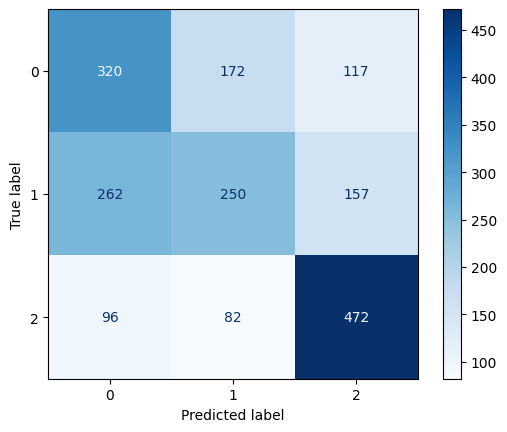

In [16]:
# Matriz de confusão
cm = confusion_matrix(y_test, reg_test_predict)

print("Matriz de Confusão:")
print(cm)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=reg_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [17]:
# Salvando o classifier para uso futuro
print("O modelo do scaler foi salvo em:")
dump(reg_classifier, 'models/stage_classifier.joblib')

O modelo do scaler foi salvo em:


['models/stage_classifier.joblib']

---
## **Árvore de Decisão**
---

* Agora vamos tentar outra alternativa de classificação. Dessa vez, vamos tentar utilizar o modelo 'Árvore de Decisão', que pode ser útil para nos ajudar a visualizar melhor o que está acontecendo no processo de classificação, e talvez até entregue resultados melhores na acurácia e precisão. 

* Perceba que podemos utilizar as mesmas variáveis X e Y, já que não foram modificadas.

In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text # Modelo de Árvore de Decisão, plotagem da árvore

In [19]:
# Instanciando Árvore de decisão
arvore = DecisionTreeClassifier(
    random_state=42, 
    min_impurity_decrease=9.1e-05,
    )

O parâmetro min_impurity_decrease em uma árvore de decisão é um critério de parada que controla a criação de nós adicionais na árvore de decisão. Ele é usado para regular a complexidade da árvore, evitando o overfitting ao limitar a profundidade e o número de nós da árvore.

O valor passado foi encontrado com a análise da acurácia com base no aumento ou diminuição do parâmetro.

In [20]:
# Treinando o modelo
arvore.fit(X_train, y_train)

DecisionTreeClassifier(min_impurity_decrease=9.1e-05, random_state=42)

In [21]:
# Realizando as predições
arvore_predict = arvore.predict(X_test)

In [22]:
# Resultados do modelo
print(classification_report(y_test,arvore_predict))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       609
           1       0.75      0.72      0.73       669
           2       0.82      0.83      0.83       650

    accuracy                           0.77      1928
   macro avg       0.77      0.77      0.77      1928
weighted avg       0.77      0.77      0.77      1928



Perceba que o modelo de Árvore de Decisão já desenvolveu uma acurácia melhor do que o de Regressão Logística, apresentando 77% de acurácia.

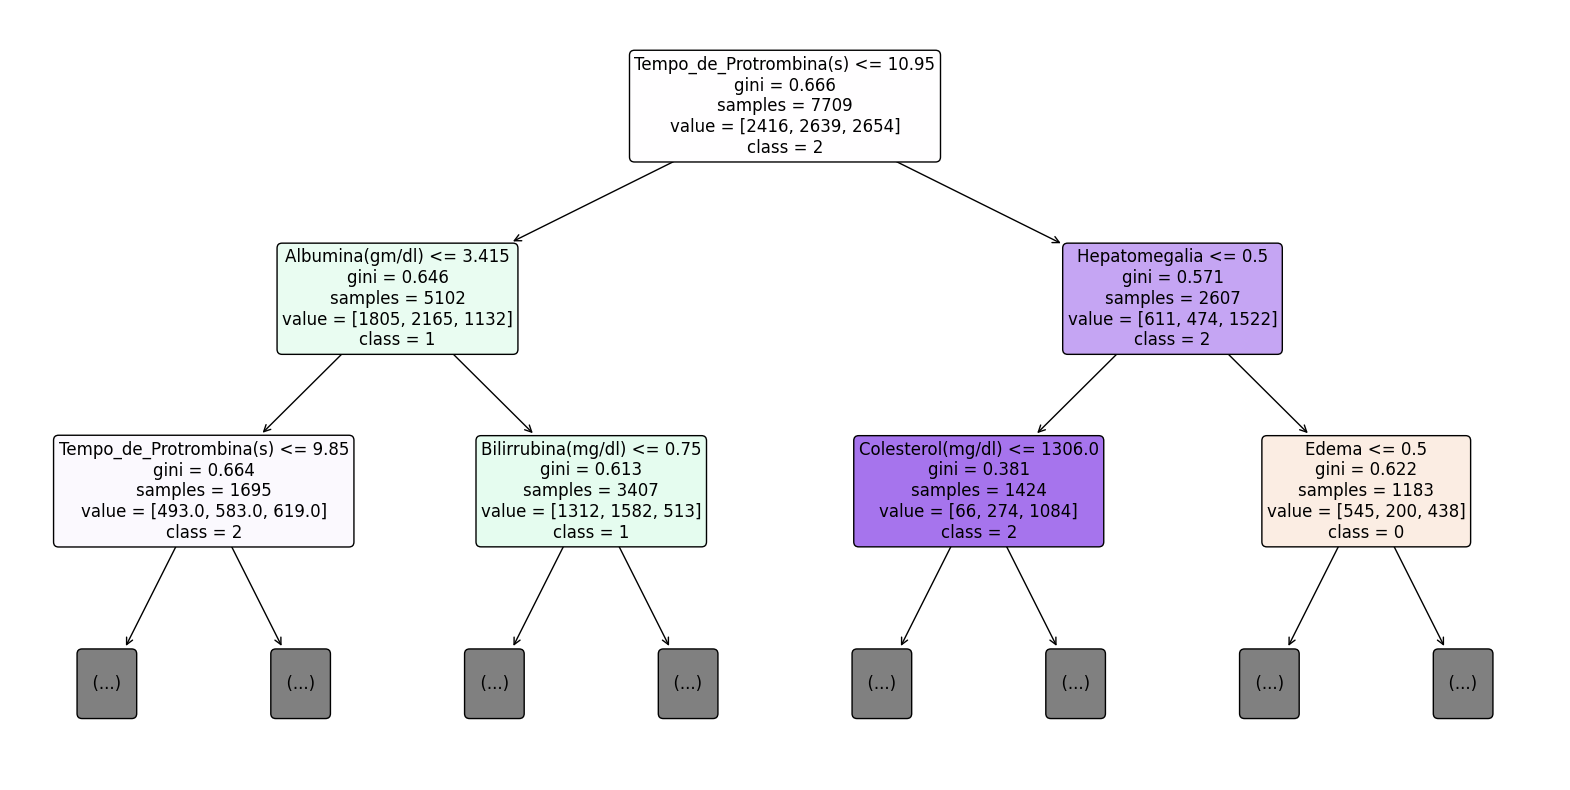

In [23]:
# Plotando a árvore com os valores desnormalizados
plt.figure(figsize=(20,10))
plot_tree(
    arvore, 
    feature_names=df.drop(columns=['Estágio']).columns, 
    class_names=[str(cls) for cls in arvore.classes_], 
    filled=True, 
    rounded=True, 
    fontsize=12,
    max_depth=2,
)
plt.show()

Agora vamos realizar um teste que consiste na predição dos dados de treino, para checar uma possibilidade de _overfitting_.

In [24]:
# Realizando as predições com os dados de treino para checar possibilidade de overfitting
arvore_predict_train = arvore.predict(X_train)

In [25]:
# Resultados dos dados de treino
print(classification_report(y_train, arvore_predict_train))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2416
           1       0.97      0.97      0.97      2639
           2       0.98      0.98      0.98      2654

    accuracy                           0.97      7709
   macro avg       0.97      0.97      0.97      7709
weighted avg       0.97      0.97      0.97      7709



Perceba que o modelo apresentou quase 100% de acurácia com os dados de treino, o que pode ser um indicativo de _overfitting_. 

Para evitar isso, vamos realizar uma técnica chamada Grid Search para encontrar o melhor valor para o **ccp_alpha**, um parâmetro que nos ajuda a regularizar a árvore e evitar _overfitting_.

#### **Realizando o Grid Search**


In [26]:
from sklearn.model_selection import GridSearchCV # Algoritmo Grid Search

In [27]:
# Instanciando nova árvore
arvore_teste = DecisionTreeClassifier()

In [28]:
# Criando o caminho da poda de complexidade de custo
path = arvore_teste.cost_complexity_pruning_path(X_train_scaled, y_train)

In [29]:
# Realizando o Grid Search
param_grid = {'ccp_alpha':path.ccp_alphas}

CV_clf = GridSearchCV(
    estimator=arvore, 
    param_grid=param_grid, 
    cv=7, 
    verbose=2, 
    n_jobs=-1
    )

CV_clf.fit(X_train, y_train)

Fitting 7 folds for each of 927 candidates, totalling 6489 fits


GridSearchCV(cv=7,
             estimator=DecisionTreeClassifier(min_impurity_decrease=9.1e-05,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.85312158e-05, 1.98667990e-05, 2.16197518e-05, 2.16197518e-05,
       2.16197518e-05, 2.16197518e-05, 2.16197518e-05, 2.31640198e-05,
       2.52230438e-05, 2.60237753e-05, 2...
       2.56832778e-03, 2.62975314e-03, 2.79555704e-03, 2.82106876e-03,
       2.89601723e-03, 2.90475807e-03, 3.00526927e-03, 3.03808208e-03,
       3.11106202e-03, 3.13070223e-03, 3.20548642e-03, 3.26621370e-03,
       3.37321464e-03, 3.55273106e-03, 4.05480584e-03, 4.48300874e-03,
       5.75736363e-03, 7.30300602e-03, 8.47447562e-03, 1.01947498e-02,
       1.29971373e-02, 2.72504572e-02, 4.56753199e-02])},
             verbose=2)

* Com o valor em mãos, agora vamos criar outra árvore de decisão com os parâmetros modifiados, com o objetivo de verificar se há uma diferença na qualidade do modelo.

In [30]:
# Atribuindo os novos parâmetros
ccp_alpha = CV_clf.best_estimator_.ccp_alpha

In [31]:
# Instanciando uma nova árvore com o ccp_alpha
arvore_2 = DecisionTreeClassifier(
    random_state=42, 
    ccp_alpha=ccp_alpha,
    min_impurity_decrease=9.1e-05,
    )

In [32]:
# Treinando a nova árvore
arvore_2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.00029186664937086524,
                       min_impurity_decrease=9.1e-05, random_state=42)

In [33]:
# Realizando as novas predições
arvore_2_predict = arvore_2.predict(X_test)

In [34]:
# Resultados do novo modelo
print(classification_report(y_test, arvore_2_predict))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       609
           1       0.75      0.73      0.74       669
           2       0.81      0.81      0.81       650

    accuracy                           0.77      1928
   macro avg       0.77      0.77      0.77      1928
weighted avg       0.77      0.77      0.77      1928



Não houve mudança significativa nos resultados do novo modelo.

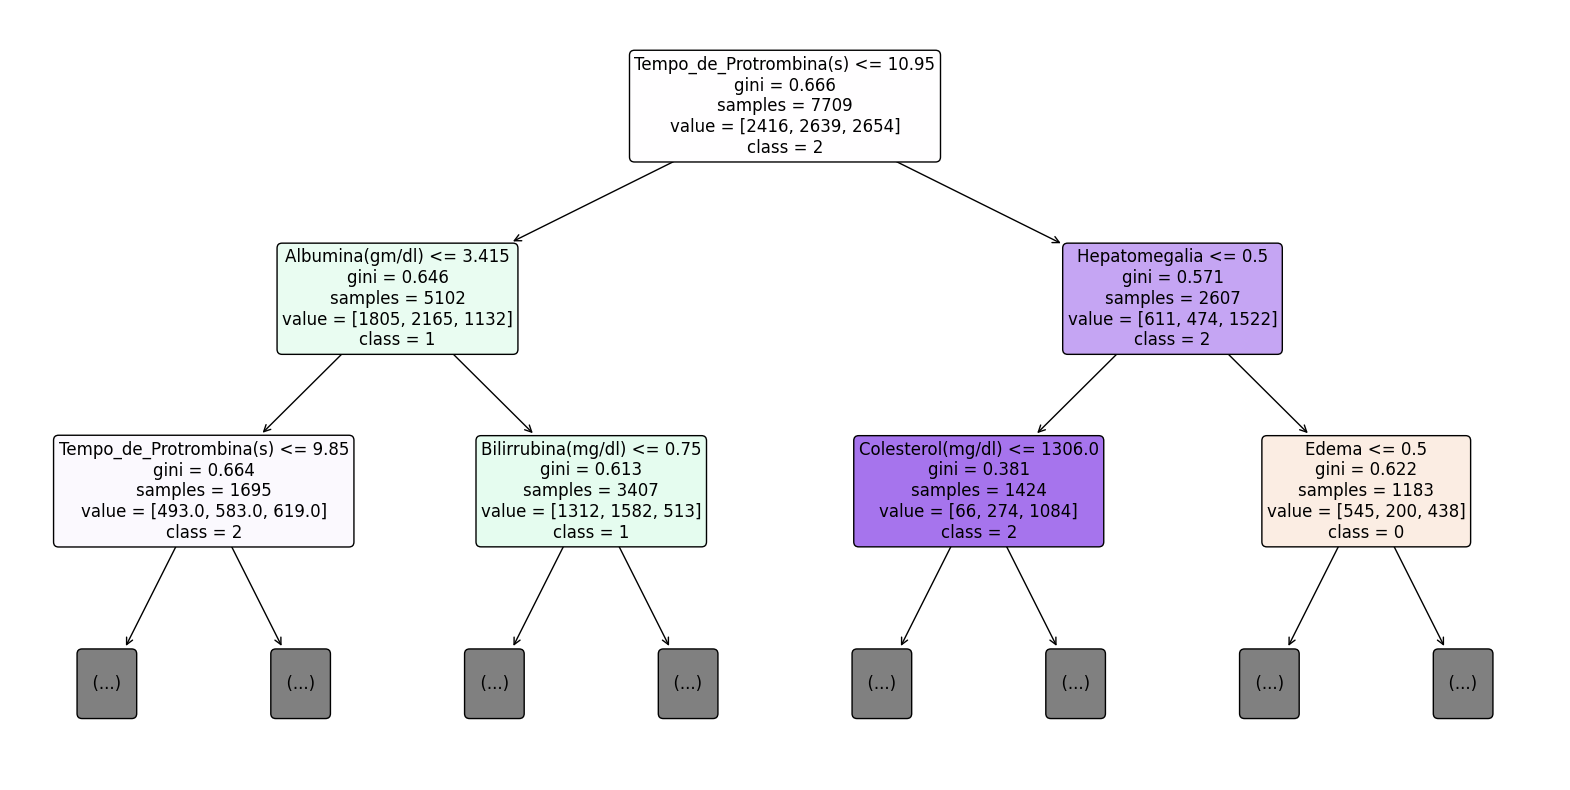

In [35]:
# Plotando a nova árvore
plt.figure(figsize=(20,10))
plot_tree(
    arvore_2, 
    feature_names=df.drop(columns=['Estágio']).columns, 
    class_names=[str(cls) for cls in arvore_2.classes_], 
    filled=True, 
    rounded=True, 
    fontsize=12,
    max_depth=2,
    )
plt.show()

Agora, vamos realizar o mesmo procedimento feito com o primeiro modelo, que consiste em realizar as predições com os dados de treino, e comparar com os resultados anteriores.

In [36]:
# Realizando predições dos dados de treino para comparar com os resultados
# de antes do Grid Search
arvore_2_predict_train = arvore_2.predict(X_train)

In [37]:
# Resultados dos dados de treino
print(classification_report(y_train, arvore_2_predict_train))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2416
           1       0.87      0.89      0.88      2639
           2       0.92      0.92      0.92      2654

    accuracy                           0.89      7709
   macro avg       0.89      0.89      0.89      7709
weighted avg       0.89      0.89      0.89      7709



Opa! Perceba que a acurácia com os dados de treino caiu para 89%, porém a acurácia com os dados de teste permaneceu a mesma. Isso indica que o modelo reduziu o fator de _overfitting_ sem prejudicar a acurácia com dados de teste.

In [38]:
# Obter a importância das variáveis
importances = arvore_2.feature_importances_
feature_importance_tree = pd.DataFrame(
    importances, 
    index=df.drop('Estágio', axis=1).columns, 
    columns=['Importance']
    ).sort_values(by='Importance', ascending=False)

print("Importância das Variáveis:\n")
print(feature_importance_tree)

Importância das Variáveis:

                                 Importance
Tempo_de_Protrombina(s)            0.205833
Albumina(gm/dl)                    0.176804
Plaquetas(ml/1000)                 0.144813
Hepatomegalia                      0.087253
Idade                              0.078663
Bilirrubina(mg/dl)                 0.068347
Cobre_Urina(ug/dia)                0.046128
Aspartato_Aminotransferase(U/L)    0.042780
Edema                              0.035620
Fosfatase_Alcalina (U/L)           0.033128
Triglicerídeos(mg/dl)              0.026029
Colesterol(mg/dl)                  0.022866
Telangiectasia                     0.018886
Ascite                             0.011008
Sexo Masculino                     0.001843


As variáveis estão ordenadas em ordem decrescente com base no quanto ela influencia o resultado de uma predição. As primeiras são as que mais influenciam e as últimas são as que não apresentam tanta influência, em termos de proporção.

Matriz de Confusão:
[[472  98  39]
 [ 99 489  81]
 [ 58  65 527]]


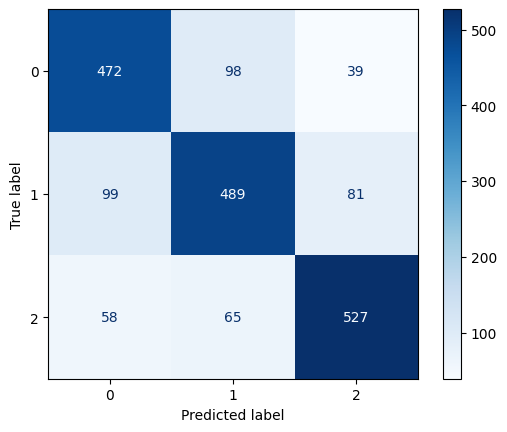

In [39]:
# Matriz de confusão
cm_tree = confusion_matrix(y_test, arvore_2_predict)

print("Matriz de Confusão:")
print(cm_tree)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree,display_labels=arvore_2.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [40]:
# Salvando o classifier para uso futuro
print("O modelo foi salvo em:")
dump(arvore_2, 'models/decision_tree.joblib')

O modelo foi salvo em:


['models/decision_tree.joblib']

#### **Modelo LGBM**

In [41]:
import lightgbm as lgb

In [42]:
lgb = lgb.LGBMClassifier(n_jobs=-1,)
lgb.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 7709, number of used features: 15
[LightGBM] [Info] Start training from score -1.160275
[LightGBM] [Info] Start training from score -1.071988
[LightGBM] [Info] Start training from score -1.066321


LGBMClassifier(n_jobs=-1)

##### Teste

In [43]:
lgb_predict = lgb.predict(X_test_scaled)

In [44]:
print(classification_report(y_test, lgb_predict))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       609
           1       0.89      0.89      0.89       669
           2       0.94      0.93      0.93       650

    accuracy                           0.91      1928
   macro avg       0.91      0.90      0.91      1928
weighted avg       0.91      0.91      0.91      1928



##### Treino

In [45]:
lgb_predict_train = lgb.predict(X_train_scaled)

In [46]:
print(classification_report(y_train, lgb_predict_train))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2416
           1       0.94      0.96      0.95      2639
           2       0.97      0.97      0.97      2654

    accuracy                           0.96      7709
   macro avg       0.96      0.96      0.96      7709
weighted avg       0.96      0.96      0.96      7709



#### **Modelo XGBoost**

In [47]:
from xgboost import XGBClassifier

In [48]:
xgb = XGBClassifier(ccp_alpha=ccp_alpha)
xgb.fit(X_train_scaled, y_train)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:14:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "ccp_alpha" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              ccp_alpha=0.00029186664937086524, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [49]:
pred_xgb = xgb.predict(X_test_scaled)

In [50]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       609
           1       0.89      0.88      0.89       669
           2       0.93      0.94      0.94       650

    accuracy                           0.91      1928
   macro avg       0.90      0.91      0.90      1928
weighted avg       0.90      0.91      0.91      1928



In [51]:
pred_xgb_train = xgb.predict(X_train_scaled)

In [52]:
print(classification_report(y_train, pred_xgb_train))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2416
           1       0.97      0.98      0.98      2639
           2       0.99      0.99      0.99      2654

    accuracy                           0.98      7709
   macro avg       0.98      0.98      0.98      7709
weighted avg       0.98      0.98      0.98      7709



$\Uparrow$
Overfitting

REDE NEURAL

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [136]:
NeuralNetwork = Sequential([])

#### **Modelo 1**

In [129]:
# Entrada
NeuralNetwork.add(Dense(128, activation='relu',input_shape=(X_train_scaled.shape[1],)))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.2))
# 1 camada5
NeuralNetwork.add(Dense(128, activation='relu'))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.2))
# Saída camada
NeuralNetwork.add(Dense(3, activation='softmax'))

#### **Modelo 2**

In [137]:
# Entrada
NeuralNetwork.add(Dense(64, activation='relu',input_shape=(X_train_scaled.shape[1],)))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.1))
# 1 camada5
NeuralNetwork.add(Dense(128, activation='relu',))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.2))
# 2 camada
NeuralNetwork.add(Dense(64, activation='relu',))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.1))
# 2 camada
NeuralNetwork.add(Dense(128, activation='relu',))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.2))
# 2 camada
NeuralNetwork.add(Dense(64, activation='relu',))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.1))
# Saída camada
NeuralNetwork.add(Dense(3, activation='softmax'))

#### **Modelo 3**

In [148]:
# Entrada
NeuralNetwork.add(Dense(128, activation='relu',input_shape=(X_train_scaled.shape[1],)))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.2))
# 1 camada
NeuralNetwork.add(Dense(128, activation='relu'))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.2))
# 2 camada
NeuralNetwork.add(Dense(64, activation='relu'))
NeuralNetwork.add(BatchNormalization())
NeuralNetwork.add(Dropout(0.2))
# 3 camada
NeuralNetwork.add(Dense(64, activation='relu'))
NeuralNetwork.add(Dropout(0.2))
# 4 camada
NeuralNetwork.add(Dense(32, activation='relu'))
NeuralNetwork.add(Dropout(0.2))
# Saída camada
NeuralNetwork.add(Dense(3, activation='softmax'))

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [138]:
NeuralNetwork.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'],
    )

In [139]:
NeuralNetwork.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,163 (141.26 KB)

 Trainable params: 35,267 (137.76 KB)

 Non-trainable params: 896 (3.50 KB)

In [140]:
history = NeuralNetwork.fit(
    X_train_scaled, y_train, 
    epochs=600, 
    batch_size=32, 
    validation_data=(X_test_scaled, y_test)
    )

Epoch 1/600
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4396 - loss: 1.2453 - val_accuracy: 0.5441 - val_loss: 0.9053
Epoch 2/600
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5087 - loss: 0.9871 - val_accuracy: 0.5804 - val_loss: 0.8589
Epoch 3/600
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5261 - loss: 0.9470 - val_accuracy: 0.6037 - val_loss: 0.8315
Epoch 4/600
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5594 - loss: 0.9080 - val_accuracy: 0.6017 - val_loss: 0.8192
Epoch 5/600
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5736 - loss: 0.8835 - val_accuracy: 0.6214 - val_loss: 0.8083
Epoch 6/600
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5807 - loss: 0.8780 - val_accuracy: 0.6328 - val_loss: 0.7911
Epoch 7/600
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6123 - loss: 0.8383 - val_accuracy: 0.6432 - val_loss: 0.7908
Epoch 8/600
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6097 - loss: 0.8361 - val_acc

In [141]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

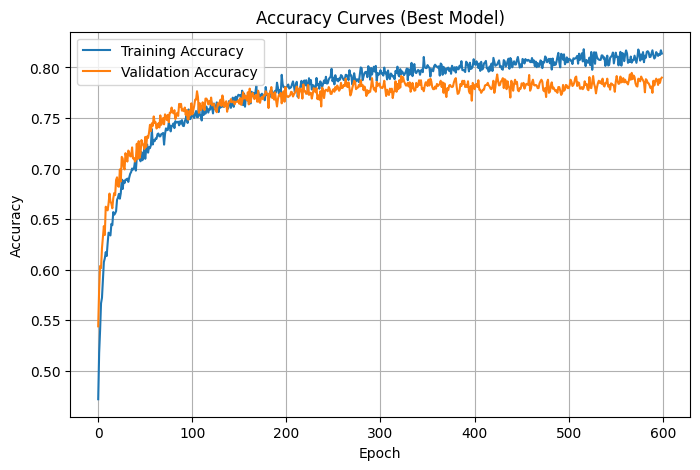

In [142]:
# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

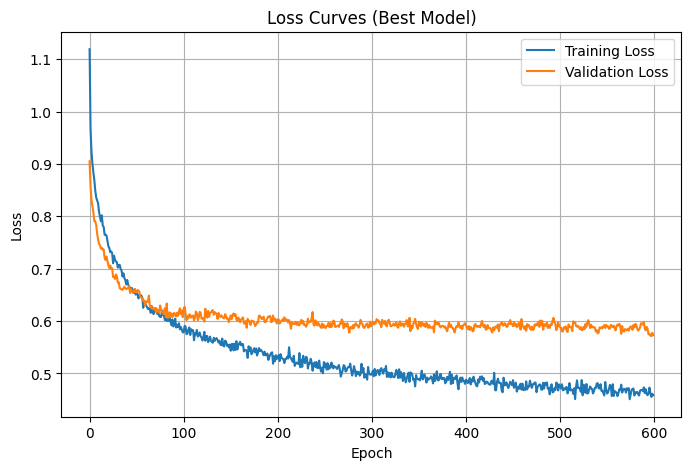

In [143]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [144]:
print(classification_report(y_test, np.argmax(NeuralNetwork.predict(X_test_scaled), axis=1)))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       609
           1       0.77      0.74      0.75       669
           2       0.81      0.86      0.84       650

    accuracy                           0.79      1928
   macro avg       0.79      0.79      0.79      1928
weighted avg       0.79      0.79      0.79      1928



In [145]:
print(classification_report(y_train, np.argmax(NeuralNetwork.predict(X_train_scaled), axis=1)))

241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2416
           1       0.91      0.92      0.91      2639
           2       0.95      0.96      0.95      2654

    accuracy                           0.93      7709
   macro avg       0.93      0.93      0.93      7709
weighted avg       0.93      0.93      0.93      7709

